# Desafio 6

Neste desafio, vamos praticar _feature engineering_, um dos processos mais importantes e trabalhosos de ML. Utilizaremos o _data set_ [Countries of the world](https://www.kaggle.com/fernandol/countries-of-the-world), que contém dados sobre os 227 países do mundo com informações sobre tamanho da população, área, imigração e setores de produção.

> Obs.: Por favor, não modifique o nome das funções de resposta.

## _Setup_ geral

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk

from sklearn.preprocessing import (
    OneHotEncoder, Binarizer, KBinsDiscretizer,
    MinMaxScaler, StandardScaler, PolynomialFeatures
)

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import (
    CountVectorizer, TfidfVectorizer
)

In [33]:
# Algumas configurações para o matplotlib.
#%matplotlib inline

from IPython.core.pylabtools import figsize


figsize(12, 8)

sns.set()

In [34]:
countries = pd.read_csv("countries.csv")

In [35]:
new_column_names = [
    "Country", "Region", "Population", "Area", "Pop_density", "Coastline_ratio",
    "Net_migration", "Infant_mortality", "GDP", "Literacy", "Phones_per_1000",
    "Arable", "Crops", "Other", "Climate", "Birthrate", "Deathrate", "Agriculture",
    "Industry", "Service"
]

countries.columns = new_column_names

countries.head(5)

,Country,Region,Population,Area,Pop_density,Coastline_ratio,Net_migration,Infant_mortality,GDP,Literacy,Phones_per_1000,Arable,Crops,Other,Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,"48,0","0,00","23,06","163,07",700.0,"36,0","3,2","12,13","0,22","87,65",1,"46,6","20,34","0,38","0,24","0,38"
1,Albania,EASTERN EUROPE,3581655,28748,"124,6","1,26","-4,93","21,52",4500.0,"86,5","71,2","21,09","4,42","74,49",3,"15,11","5,22","0,232","0,188","0,579"
2,Algeria,NORTHERN AFRICA,32930091,2381740,"13,8","0,04","-0,39",31,6000.0,"70,0","78,1","3,22","0,25","96,53",1,"17,14","4,61","0,101","0,6","0,298"
3,American Samoa,OCEANIA,57794,199,"290,4","58,29","-20,71","9,27",8000.0,"97,0","259,5",10,15,75,2,"22,46","3,27",NaN,NaN,NaN
4,Andorra,WESTERN EUROPE,71201,468,"152,1","0,00","6,6","4,05",19000.0,"100,0","497,2","2,22",0,"97,78",3,"8,71","6,25",NaN,NaN,NaN


In [36]:
countries.dropna(inplace = True)

## Observações

Esse _data set_ ainda precisa de alguns ajustes iniciais. Primeiro, note que as variáveis numéricas estão usando vírgula como separador decimal e estão codificadas como strings. Corrija isso antes de continuar: transforme essas variáveis em numéricas adequadamente.

Além disso, as variáveis `Country` e `Region` possuem espaços a mais no começo e no final da string. Você pode utilizar o método `str.strip()` para remover esses espaços.

## Inicia sua análise a partir daqui

In [37]:
#lista so com colunas strings
types = list(countries.select_dtypes(exclude = ['int64', 'float64'])) 

In [38]:
#eliminando country e region da lista
del types[0:2]

In [39]:
#tirando as virgulas e colocando ponto
countries[types] = countries[types].replace(',', '.', regex = True).astype(float)

In [40]:
countries['Country'] = countries['Country'].str.strip()
countries['Region'] = countries['Region'].str.strip()

In [58]:
countries['Region'] 

0      ASIA (EX. NEAR EAST)
1            EASTERN EUROPE
2           NORTHERN AFRICA
6       LATIN AMER. & CARIB
7       LATIN AMER. & CARIB
               ...         
218     LATIN AMER. & CARIB
219    ASIA (EX. NEAR EAST)
224               NEAR EAST
225      SUB-SAHARAN AFRICA
226      SUB-SAHARAN AFRICA
Name: Region, Length: 179, dtype: object

## Questão 1

Quais são as regiões (variável `Region`) presentes no _data set_? Retorne uma lista com as regiões únicas do _data set_ com os espaços à frente e atrás da string removidos (mas mantenha pontuação: ponto, hífen etc) e ordenadas em ordem alfabética.

In [41]:
def q1():
    region = pd.Series(countries.Region.unique())   
    
    lista = list(region.sort_values(ascending = True))
    
    return lista

## Questão 2

Discretizando a variável `Pop_density` em 10 intervalos com `KBinsDiscretizer`, seguindo o encode `ordinal` e estratégia `quantile`, quantos países se encontram acima do 90º percentil? Responda como um único escalar inteiro.

In [42]:
def q2():
    discretizer = KBinsDiscretizer(n_bins=10, encode="ordinal", strategy="quantile")
    
    popdensity = discretizer.fit_transform(countries[['Pop_density']])
    
    quantile = np.quantile(popdensity, 0.9)
    
    return popdensity[popdensity>quantile].shape[0]

# Questão 3

Se codificarmos as variáveis `Region` e `Climate` usando _one-hot encoding_, quantos novos atributos seriam criados? Responda como um único escalar.

In [43]:
def q3():    
    df = countries[['Region', 'Climate']].copy()
    
    df.fillna(0,inplace = True)
    
    one_hot_encoder = OneHotEncoder(sparse=False, dtype=np.int)
    
    df_encoded = one_hot_encoder.fit_transform(df[["Region", "Climate"]])
    
    return df_encoded.shape[1]

## Questão 4

Aplique o seguinte _pipeline_:

1. Preencha as variáveis do tipo `int64` e `float64` com suas respectivas medianas.
2. Padronize essas variáveis.

Após aplicado o _pipeline_ descrito acima aos dados (somente nas variáveis dos tipos especificados), aplique o mesmo _pipeline_ (ou `ColumnTransformer`) ao dado abaixo. Qual o valor da variável `Arable` após o _pipeline_? Responda como um único float arredondado para três casas decimais.

In [44]:
test_country = [
    'Test Country', 'NEAR EAST', -0.19032480757326514,
    -0.3232636124824411, -0.04421734470810142, -0.27528113360605316,
    0.13255850810281325, -0.8054845935643491, 1.0119784924248225,
    0.6189182532646624, 1.0074863283776458, 0.20239896852403538,
    -0.043678728558593366, -0.13929748680369286, 1.3163604645710438,
    -0.3699637766938669, -0.6149300604558857, -0.854369594993175,
    0.263445277972641, 0.5712416961268142
]

In [45]:
def q4():    
    num_pipeline = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())])

    num_pipeline.fit(countries.select_dtypes([np.number]))

    return num_pipeline.transform([test_country[2:]])[0][9].round(3)

## Questão 5

Descubra o número de _outliers_ da variável `Net_migration` segundo o método do _boxplot_, ou seja, usando a lógica:

$$x \notin [Q1 - 1.5 \times \text{IQR}, Q3 + 1.5 \times \text{IQR}] \Rightarrow x \text{ é outlier}$$

que se encontram no grupo inferior e no grupo superior.

Você deveria remover da análise as observações consideradas _outliers_ segundo esse método? Responda como uma tupla de três elementos `(outliers_abaixo, outliers_acima, removeria?)` ((int, int, bool)).

In [46]:
net_migration = countries['Net_migration']

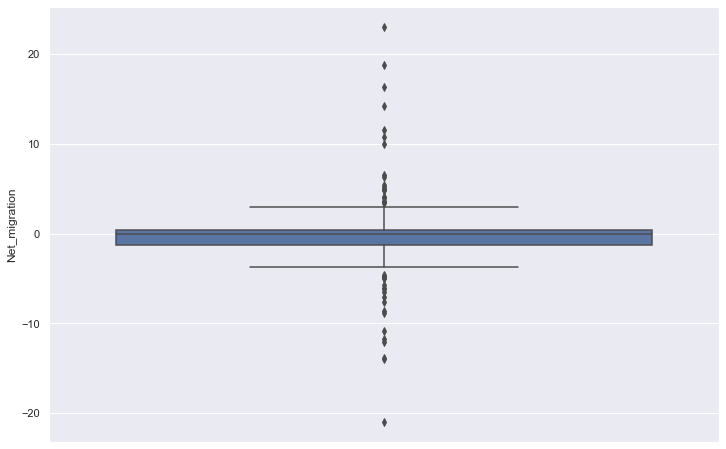

In [47]:
sns.boxplot(net_migration, orient = 'vertical');

In [48]:
q1 = net_migration.quantile(0.25)
q3 = net_migration.quantile(0.75)

iqr = q3 - q1

outlier_interval_iqr = [q1 - (1.5 * iqr), q3 + (1.5 * iqr)]

print(outlier_interval_iqr)

[-3.88, 2.96]


In [49]:
outliers = net_migration[(net_migration < outlier_interval_iqr[0]) | (net_migration > outlier_interval_iqr[1])]

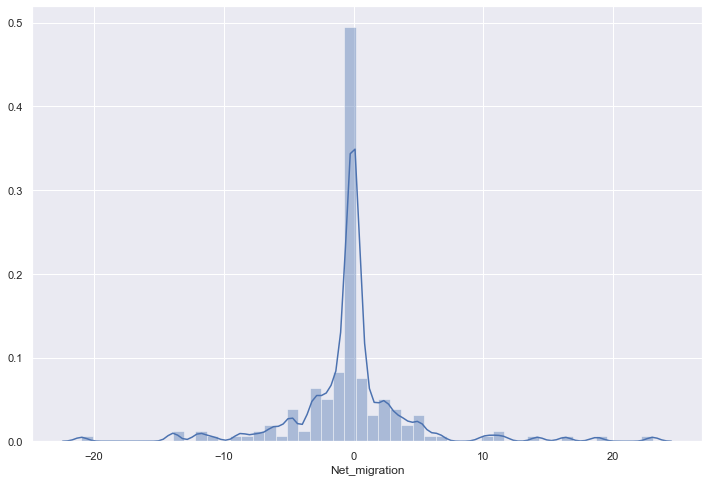

In [50]:
sns.distplot(net_migration);

In [51]:
net_migration_sem_outliers = net_migration.drop(index = outliers.index)

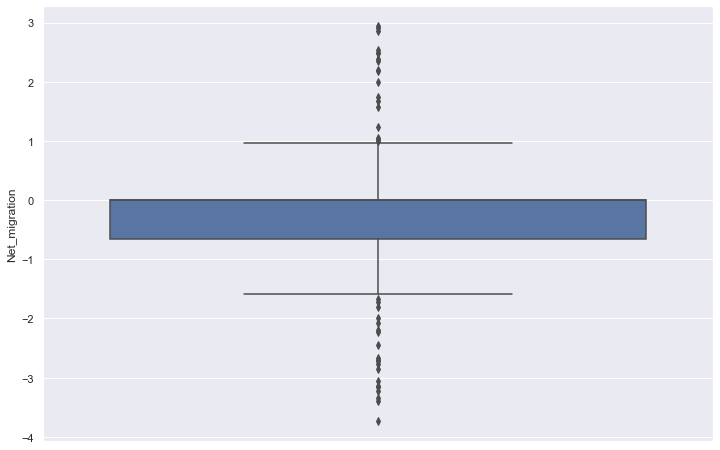

In [52]:
sns.boxplot(net_migration_sem_outliers, orient = 'vertical');

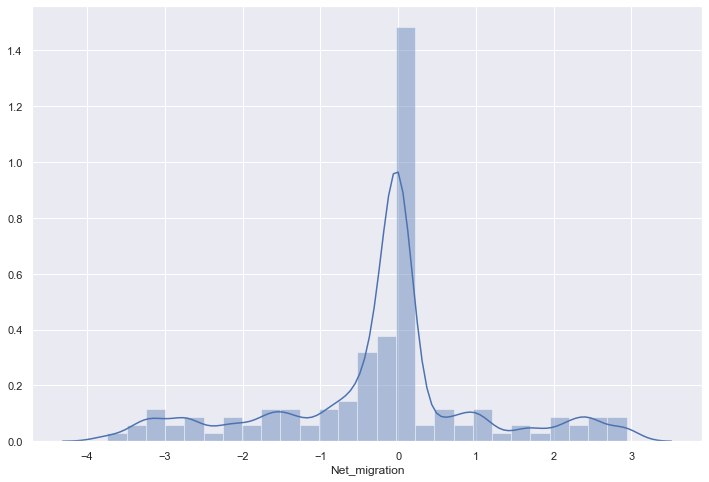

In [53]:
sns.distplot(net_migration_sem_outliers);

In [54]:
def q5():
    q1 = net_migration.quantile(0.25)
    q3 = net_migration.quantile(0.75)

    iqr = q3 - q1
    
    min_interval = q1 - (1.5 * iqr)
    max_interval = q3 + (1.5 * iqr)
    
    outliers_abaixo = len(net_migration[(net_migration < min_interval)])
    outliers_acima = len(net_migration[(net_migration < max_interval)])                                    

    return tuple((outliers_abaixo, outliers_acima, False))

## Questão 6
Para as questões 6 e 7 utilize a biblioteca `fetch_20newsgroups` de datasets de test do `sklearn`

Considere carregar as seguintes categorias e o dataset `newsgroups`:

```
categories = ['sci.electronics', 'comp.graphics', 'rec.motorcycles']
newsgroup = fetch_20newsgroups(subset="train", categories=categories, shuffle=True, random_state=42)
```


Aplique `CountVectorizer` ao _data set_ `newsgroups` e descubra o número de vezes que a palavra _phone_ aparece no corpus. Responda como um único escalar.

In [55]:
categories = ['sci.electronics', 'comp.graphics', 'rec.motorcycles']

newsgroups = fetch_20newsgroups(subset = "train", categories = categories, shuffle = True, random_state = 42)

In [56]:
def q6():
    count_vectorizer = CountVectorizer()
    newsgroups_counts = count_vectorizer.fit_transform(newsgroups.data)

    word_phone_idx = count_vectorizer.vocabulary_.get('phone')
    
    return int(newsgroups_counts[:, word_phone_idx].sum())

## Questão 7

Aplique `TfidfVectorizer` ao _data set_ `newsgroups` e descubra o TF-IDF da palavra _phone_. Responda como um único escalar arredondado para três casas decimais.

In [57]:
def q7():
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_vectorizer.fit(newsgroups.data)
    newsgroups_tfidf_vectorized = tfidf_vectorizer.transform(newsgroups.data)
    
    word_phone_idx = tfidf_vectorizer.vocabulary_.get('phone')

    return float(round((newsgroups_tfidf_vectorized[:, word_phone_idx].sum()), 3))